In [24]:
#%pip install "tensorflow<2.11"

In [25]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.python.client import device_lib

import gym
from gym.envs.registration import register
from tickerData import *


import warnings
warnings.filterwarnings('ignore')

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
sns.set_style('whitegrid')

In [28]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Using GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [29]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

In [30]:
results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [31]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [32]:
trading_days = 252

In [33]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [34]:
trading_cost_bps = 1e-3
time_cost_bps = 1e-4

f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

'Trading costs: 0.10% | Time costs: 0.01%'

In [35]:
trading_environment = gym.make('trading-v0', 
                               ticker='AAPL',
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps)
trading_environment.seed(42)

INFO:trading_env:loading data for AAPL...


[*********************100%***********************]  1 of 1 completed

INFO:trading_env:None



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3074 entries, 33 to 3106
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  3074 non-null   float64
 1   ret_2    3074 non-null   float64
 2   ret_5    3074 non-null   float64
 3   ret_10   3074 non-null   float64
 4   ret_21   3074 non-null   float64
 5   rsi      3074 non-null   float64
 6   macd     3074 non-null   float64
 7   atr      3074 non-null   float64
 8   stoch    3074 non-null   float64
 9   ultosc   3074 non-null   float64
dtypes: float64(10)
memory usage: 264.2 KB


[42]

In [36]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

In [37]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=0)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values
        targets = np.reshape(targets, (-1, 1))
        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

In [38]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization
replay_capacity = int(1e6)
batch_size = 4096
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [39]:
tf.keras.backend.clear_session()

In [40]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [41]:
ddqn.online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2816      
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 69,379
Trainable params: 69,379
Non-trainable params: 0
_________________________________________________________________


In [42]:
total_steps = 0
max_episodes = 20
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

In [43]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

In [44]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav 
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav 
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)
    
    if episode % 10 == 0:
        track_results(episode, 
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), 
                      np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), 
                      np.mean(market_navs[-10:]), 
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

  10 | 00:00:02 | Agent: -25.8% (-25.8%) | Market:  26.2% ( 26.2%) | Wins: 20.0% | eps:  0.960
  20 | 00:00:59 | Agent: -25.3% (-24.9%) | Market: 160.6% (295.1%) | Wins: 15.0% | eps:  0.921


In [45]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 20
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              20 non-null     float64
 1   Market             20 non-null     float64
 2   Difference         20 non-null     float64
 3   Strategy Wins (%)  0 non-null      float64
dtypes: float64(4)
memory usage: 800.0 bytes


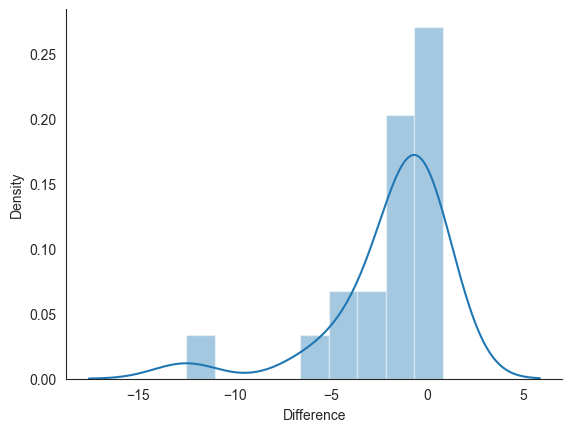

In [46]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()